# Gaussian Processes with Spectral Mixture Kernels to Implicitly Capture Hidden Structure from Data 
---------------------------------------------------------------------------------------------------

**(Note: Cross-posted with the [Haystax Technology Blog](https://haystax.com/blog/).)**

Several scientific fields, such as insider-threat detection, often lack sufficient amounts of time-series training data for the purpose of scientific discovery. Moreover, the available limited data are very noisy. For instance, Figure [1](#fig:data-emails) shows monthly attachment size in emails (in Gigabytes) sent by an insider from their employee account to their home account. 

<div id="fig:data-emails">
![Monthly email attachment size in Gigabytes\label{fig:data-emails}](https://github.com/Emaasit/long-range-extrapolation/blob/dev/code/notebooks/results/emails/data-email.png?raw=true)
</div>

## The problem
Such data a major challenge when estimating statistical models to extract hidden patterns and perform accurate forecasting. Most of the current literature in insider-threat detection and highway-safety planning involve visualizing the time-series for noticeable structure, such as periodicity, and hard coding them into pre-specified parametric functions. 

### Source code
For the impatient reader, two options are provided below to access the source code used for empirical analyses:

1. Most of the code is not shown here to keep the post concise but the code, data and results can be found [here on GitHub](https://github.com/Emaasit/long-range-extrapolation).

2. [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Emaasit/long-range-extrapolation/master?urlpath=lab) Click this icon to open the notebooks in a web browser and explore the code and data without downloading the project and installing any software.


## Related Work and Limitations
This approach is associated with two limitations. First, given that such trends may not be noticeable in small data, it is difficult to explicitly incorporate expressive structure into the statistical models during formulation.  Second, it is difficult to know *a priori* the most appropriate functional form to use. 

## Data Science Questions


## Hypothesis
To address these limitations, a nonparametric Bayesian approach was proposed to capture hidden structure from limited data and perform accurate long-range forecasting. The proposed model, a Gaussian process with a spectral mixture kernel, precludes the need to pre-specify a functional form and hard code trends. Bayesian modeling was adopted to account for uncertainty.

The mathematical details are described in a corresponding paper that can be found [here on arXiv]().

## Experiments

### The setup
Let's first install some python packages that we shall use for our analysis. Also we shall set up our plotting requirements.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 40, 'ytick.labelsize': 40, 'axes.labelsize': 40, 'font.size': 40, 'lines.linewidth': 4.0, 
      'lines.markersize': 40, 'font.family': "serif", 'font.serif': "cm", 'savefig.dpi': 200,
      'text.usetex': False, 'legend.fontsize': 40.0, 'axes.titlesize': 40, "figure.figsize": [24, 16]}
sns.set(rc = rc)
sns.set_style("darkgrid")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gpflow
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt.optim import StagedOptimizer, MCOptimizer, SciPyOptimizer  
from gpflowopt.design import LatinHyperCube

### Raw data and sample formation

First, let's read in the data using `pandas`, view the first three records and the structure of the resulting `pandas` dataframe.

In [8]:
email_filtered = pd.read_csv("../data/emails/email_filtered.csv", parse_dates=["date"])
email_filtered.head(n = 3)

,id,date,user,pc,to,cc,bcc,from,activity,size,attachments,content
0,{D0V4-N9KM15BF-0512LLVP},2010-01-04 07:36:48,BTR2026,PC-9562,Thaddeus.Brett.Daniel@dtaa.com,Zorita.Angela.Wilson@dtaa.com,NaN,Beau.Todd.Romero@dtaa.com,Send,23179,NaN,"On November 25, general Savary was sent to the..."
1,{L5E5-J1HB80OY-9539AOEC},2010-01-04 07:38:18,BTR2026,PC-9562,Beau.Todd.Romero@dtaa.com,NaN,NaN,Marsh_Travis@raytheon.com,View,17047,NaN,"Early in the morning of May 27, a boat crossed..."
2,{Q4V7-V6BR00TZ-5209UVDX},2010-01-04 07:53:35,BTR2026,PC-9562,Bianca-Clark@optonline.net,NaN,NaN,Beau_Romero@aol.com,Send,26507,NaN,The Americans never held up their side of the ...


In [9]:
email_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11920 entries, 0 to 11919
Data columns (total 12 columns):
id             11920 non-null object
date           11920 non-null datetime64[ns]
user           11920 non-null object
pc             11920 non-null object
to             11920 non-null object
cc             6101 non-null object
bcc            593 non-null object
from           11920 non-null object
activity       11920 non-null object
size           11920 non-null int64
attachments    3809 non-null object
content        11920 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 1.1+ MB


Let's filter data for a particular known insider with user ID "CDE1846".

In [10]:
df_insider = email_filtered[email_filtered["user"] == "CDE1846"]
df_insider.shape

(3165, 12)

In [11]:
emails_per_month = df_insider.resample(rule = "1M", on = "date").sum().reset_index()
emails_per_month["date"] = pd.to_datetime(emails_per_month["date"], format = "%Y-%m-%d")
emails_per_month.columns = ["ds", "y"]
emails_per_month

,ds,y
0,2010-01-31,117809274
1,2010-02-28,112461320
2,2010-03-31,134592245
3,2010-04-30,148911866
4,2010-05-31,80689085
5,2010-06-30,128024029
6,2010-07-31,115046041
7,2010-08-31,142607937
8,2010-09-30,121728119
9,2010-10-31,126041467


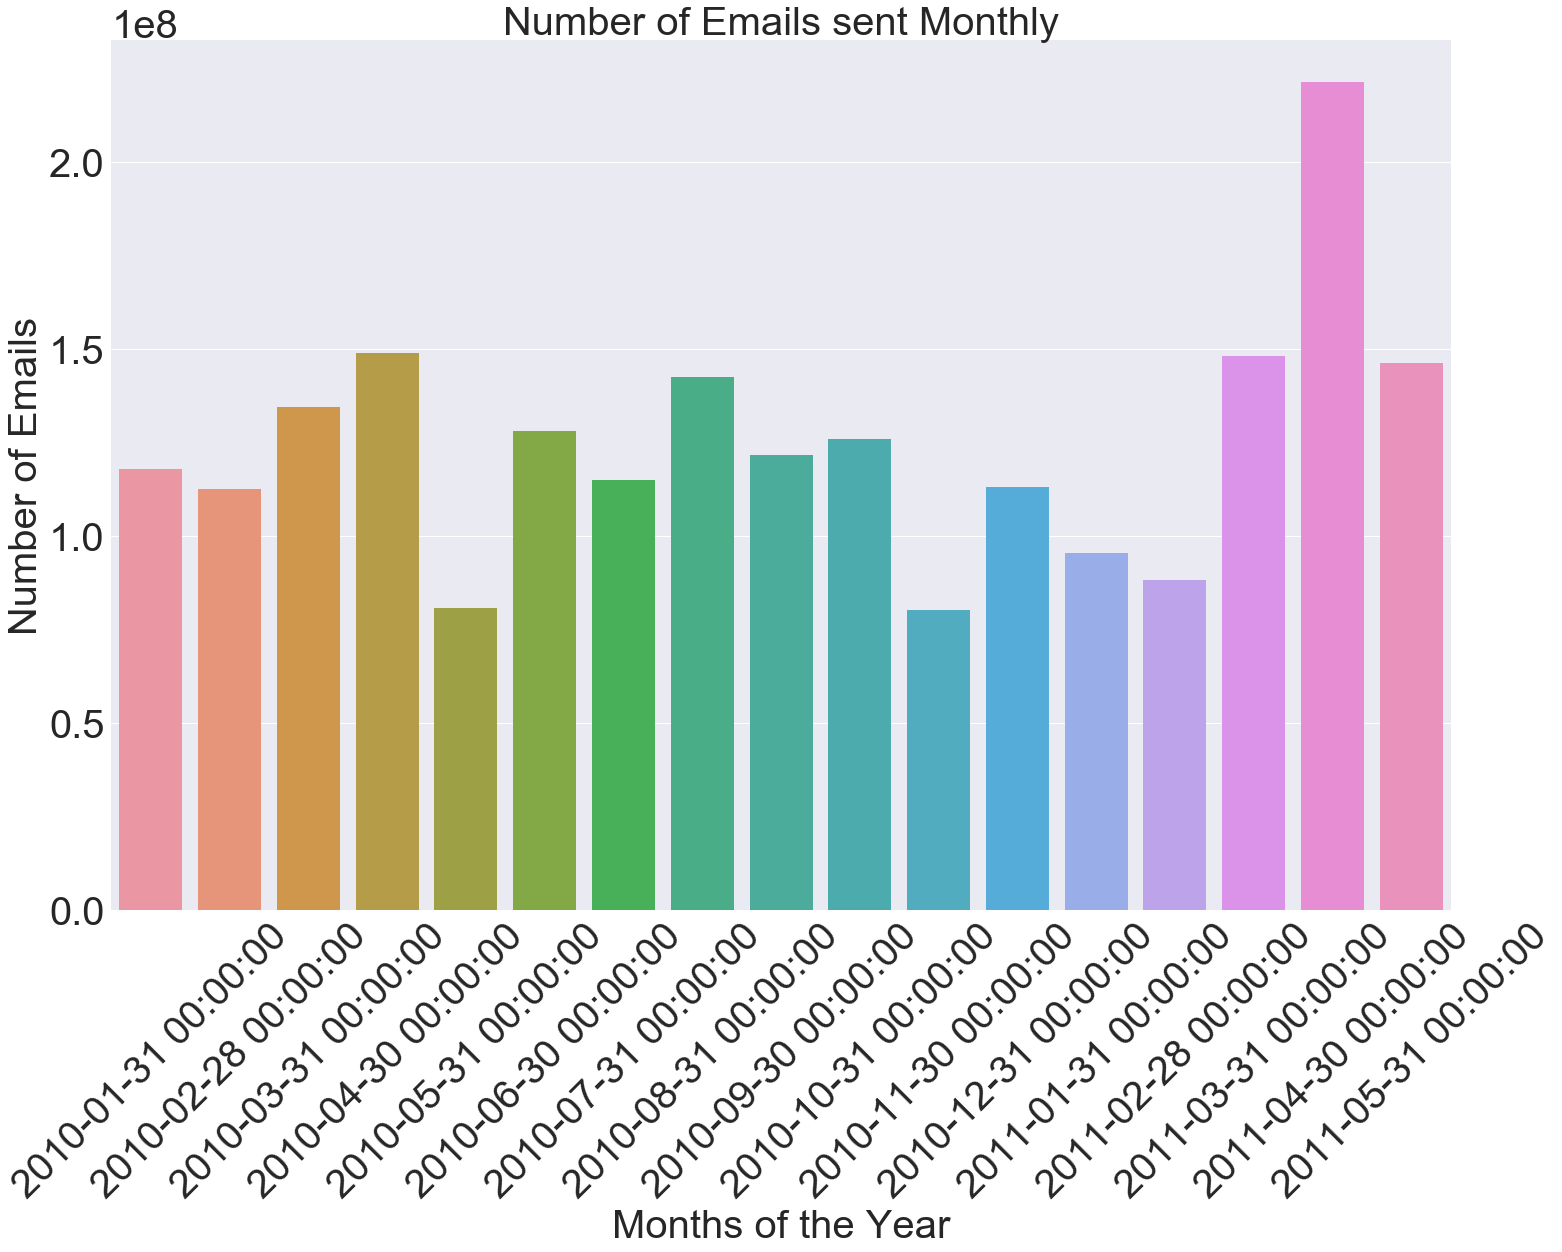

In [12]:
fig, ax = plt.subplots()
sns.barplot(data = emails_per_month, x = "ds", y = "y", ax = ax)
ax.set_xticklabels(labels = emails_per_month["ds"], rotation = 45)
ax.set_xlabel("Months of the Year")
ax.set_ylabel("Number of Emails")
ax.set_title("Number of Emails sent Monthly");

Here, we look at the case where the insider email IP to their home account. The data is resampled per month and the anomalous behavior is clearly visible

In [13]:
df_insider_non_org = df_insider[~df_insider['to'].str.contains('dtaa.com')]
df_insider_ewing = df_insider_non_org[df_insider_non_org['to'] == 'Ewing_Carlos@comcast.net']
df = df_insider_ewing.resample('1M', on='date').sum().reset_index()
df.columns = ["ds", "y"]
(df.y/1e6).describe()
df.y = df.y/1e6

count     17.000000
mean      13.042668
std       27.010948
min        0.181588
25%        2.258068
50%        4.749784
75%        6.430011
max      108.623858
Name: y, dtype: float64

In [14]:
from datetime import datetime
df["ds"] = df.apply(lambda x: datetime.date(x["ds"]), axis = 1)

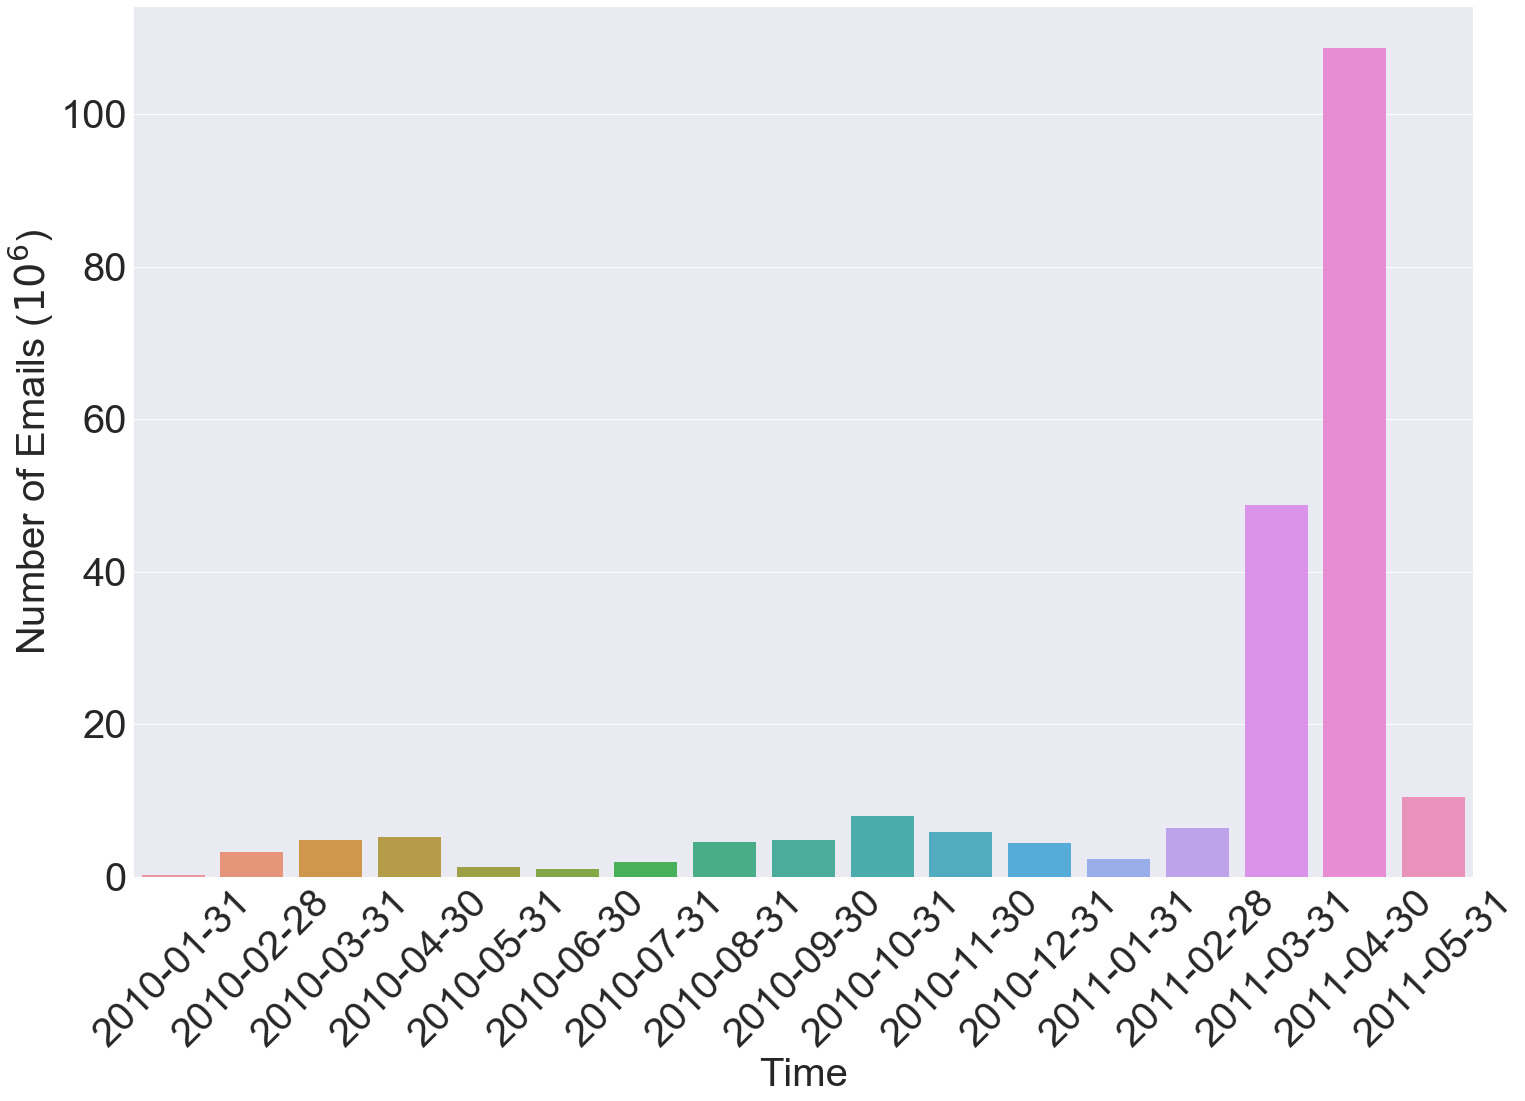

In [15]:
fig, ax = plt.subplots()
sns.barplot(data = df, x = "ds", y = "y")
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Emails ($10^6$)");
# ax.set_title("Number of Emails sent Monthly");

In [16]:
df = df.drop([14, 15, 16])

In [17]:
test_size = 11
X_complete = np.array([df.index]).reshape((df.shape[0], 1)).astype('float64')
X_train = X_complete[0:test_size, ]
X_test = X_complete[test_size:df.shape[0], ]
Y_complete = np.array([df.y]).reshape((df.shape[0], 1)).astype('float64')
Y_train = Y_complete[0:test_size, ]
Y_test = Y_complete[test_size:df.shape[0], ]
D = Y_train.shape[1];

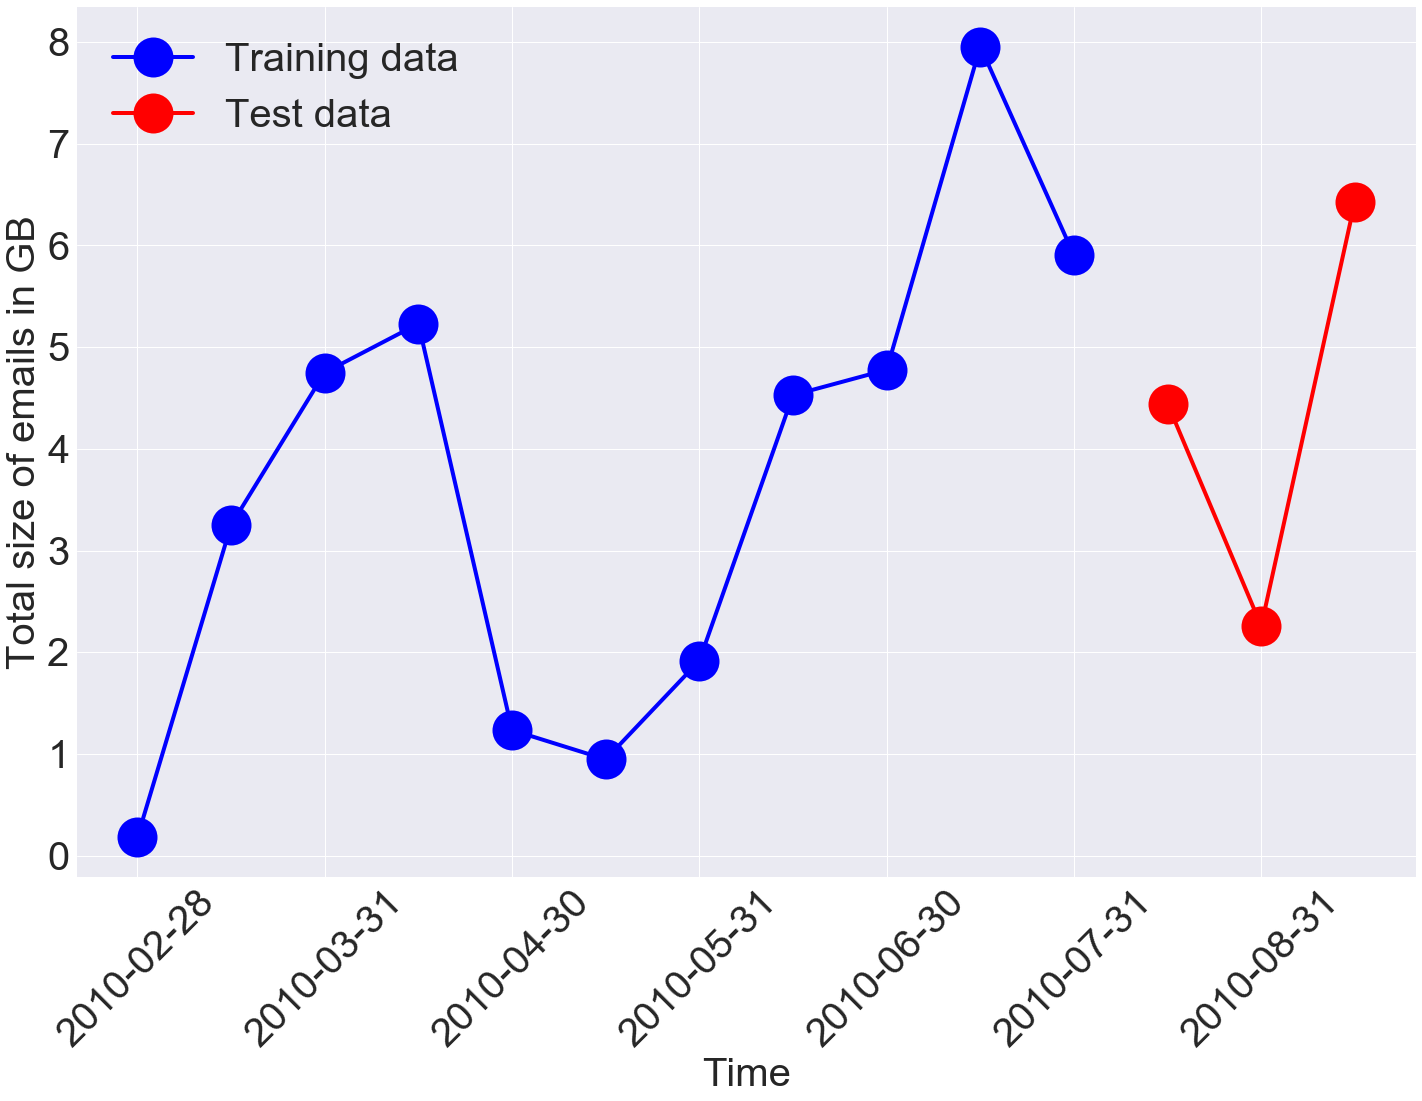

In [18]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b', marker = "o", label = "Training data")
ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Total size of emails in GB')
plt.legend(loc = "best");

### Empirical analysis

This study used a Gaussian Process model with a Spectral Mixture (SM) kernel proposed by Wilson (2014). This is because the SM kernel is capable of capturing hidden structure with data without hard cording features in a kernel. Moreover, the SM kernel is capable of performing long-range extrapolation beyond available data.


In [19]:
# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales

Q = 10 # nr of terms in the sum
max_iters = 1000

def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

m = create_model(np.ones((2*Q,)))

### Inference through Optimization of the likelihood

In [20]:
%%time
m.optimize(maxiter = max_iters)

CPU times: user 7.44 s, sys: 457 ms, total: 7.9 s
Wall time: 7.55 s


      fun: 20.868585670810997
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.99958679e-06,   1.41339465e-05,   5.09060783e-05,
         6.72588106e-06,  -1.28315446e-08,   1.22652879e-05,
         5.09060783e-05,   6.72588106e-06,  -1.28315446e-08,
         1.22652879e-05,   5.09060783e-05,   6.72588106e-06,
        -1.28315446e-08,   1.22652879e-05,   5.09060783e-05,
         6.72588106e-06,  -1.28315446e-08,   1.22652879e-05,
         5.09060783e-05,   6.72588106e-06,  -1.28315446e-08,
         1.22652879e-05,   5.09060783e-05,   6.72588106e-06,
        -1.28315446e-08,   1.22652879e-05,   5.09060783e-05,
         6.72588106e-06,  -1.28315446e-08,   1.22652879e-05,
         5.09060783e-05,   6.72588106e-06,  -1.28315446e-08,
         1.22652879e-05,   5.09060783e-05,   6.72588106e-06,
        -1.28315446e-08,   1.22652879e-05,   5.09060783e-05,
         6.72588106e-06,  -1.28315446e-08,   1.22652879e-05,
         5.10663145e-06])
  message: b'CONVERGE

In [21]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticklabels(labels = df.ds, rotation = 45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Total size of emails in GB');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='b', marker = "o", label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', marker = "o", label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

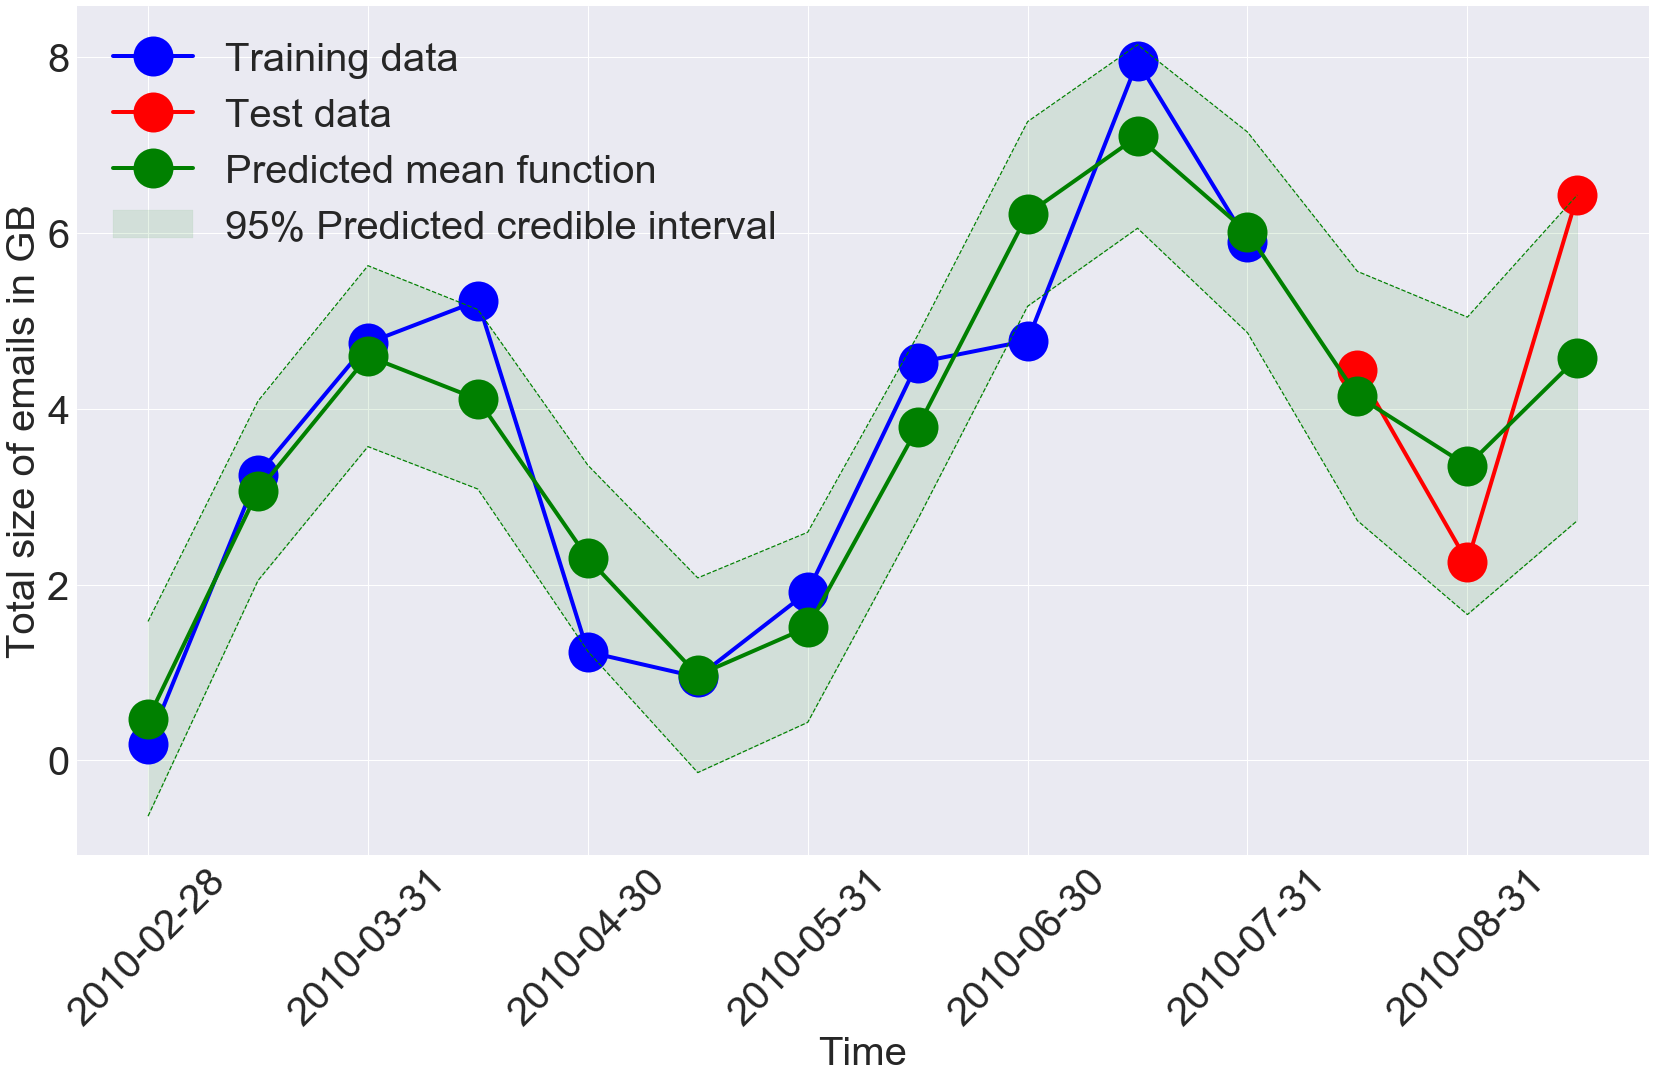

In [22]:
plotprediction(m);

In [23]:
## Calculate the RMSE and MAPE
def calculate_rmse(model, X_test, Y_test):
    mu, var = model.predict_y(X_test)
    rmse = np.sqrt(((mu - Y_test)**2).mean())
    return rmse

def calculate_mape(model, X_test, Y_test):
    mu, var = model.predict_y(X_test)
    mape = (np.absolute(((mu - Y_test)/Y_test)*100)).mean()
    return mape

In [24]:
calculate_rmse(model=m, X_test = X_test, Y_test = Y_test)
calculate_mape(model=m, X_test = X_test, Y_test = Y_test)

1.2515806168637664

27.94536660649003

In [ ]:
### Inference thro

## Perform hyperparameter tuning using Bayesian Optimization

Let's use Bayesian Optimization to find the optimal model parameters of the GP model and then use then to estimate the model and prediction.

In [ ]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

In [ ]:
%%time
design = LatinHyperCube(6, domain)
X = design.generate()

In [ ]:
%%time
Y = objectivefx(X)

In [ ]:
%%time
k_surrogate = gpflow.kernels.Matern52(input_dim = domain.size, ARD = False)

In [ ]:
%%time
model_surrogate = gpflow.gpr.GPR(X, Y, kern = k_surrogate)

In [ ]:
%%time
acq_fn = ExpectedImprovement(model_surrogate)
# acq_fn = MinValueEntropySearch(model_surrogate, domain = domain)

In [ ]:
%%time
acq_optimizer = StagedOptimizer([MCOptimizer(domain, nsamples = 5000), 
                                SciPyOptimizer(domain)])

In [ ]:
%%time
optimizer = BayesianOptimizer(domain = domain, 
                              acquisition = acq_fn, 
                              optimizer = acq_optimizer)

In [ ]:
%%time
with optimizer.silent():
    result = optimizer.optimize(objectivefx = objectivefx, n_iter = 30)

In [ ]:
print(result)

In [ ]:
%%time
m_opt = create_model(result.x[0,:])
m_opt.optimize()

In [ ]:
plotprediction(m_opt)
# plt.savefig('results/emails/model-opt-emails.png');

In [ ]:
## Inspect the evolution
f, axes = plt.subplots()
f = acq_fn.data[1][:,0]
axes.plot(np.arange(0, acq_fn.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');
# plt.savefig('results/emails/iterations-email.png');

### References
1. Emaasit, D. and Johnson, M.(2018). Capturing Structure Implicitly from Noisy Time-Series having Limited Data. arXiv preprint arXiv:xxxx.xxxx

2. Wilson

3. GPflow

### Getting Help

Incase you need help running this code or have general questions, don't hesitate to email us at <demaasit@haystax.com> or <daniel.emaasit@gmail.com>.

## Computing Environment

In [ ]:
# print system information/setup
%reload_ext watermark
%watermark -v -m -p numpy,pandas,gpflowopt,gpflow,tensorflow,matplotlib,ipywidgets,beakerx,seaborn -g